# 007_image_classification_paddy_disease
This notebook is my practice (inspired by fastai DL course partA nbs#8~11) for image classification task using a kaggle competition dataset (paddy-disease-classification)

Core ideas:
- Transfer learning of multiple models (from small to modern)
- Pretrained weights
- Fine-tune 
- with TTA technique
- Model comparison & Interpretation

In [1]:
from fastkaggle import *
from fastai.vision.all import *
import warnings
warnings.filterwarnings('ignore')
set_seed(44)

In [45]:
torch.mps.empty_cache()

## Dataset
Download from: https://www.kaggle.com/competitions/paddy-disease-classification/data (1.09 GBs)

In [3]:
path = Path('/Users/applewang/Desktop/Study_Materials_2023_2025/fastai_course/my-practice/paddy-disease-classification')
Path.BASE_PATH = path
path.ls()


(#7) [Path('submission_2.csv'),Path('test_images'),Path('.DS_Store'),Path('submission.csv'),Path('train.csv'),Path('train_images'),Path('sample_submission.csv')]

In [4]:
train_path = path/'train_images'
train_files = get_image_files(train_path)

(480, 640)


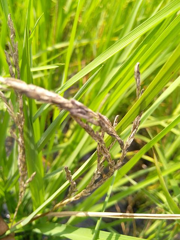

In [5]:
sample1=PILImage.create(train_files[0])
print(sample1.size)
sample1.to_thumb(240)

### fastcore.parallel
`fastcore.parallel.paralle` is powerful
- 是用来并行化计算的，它有助于加速 CPU 任务，而与 GPU 或 MPS 关系不大。它对于数据处理类任务（如图像预处理）能发挥较大作用。

In [6]:
from fastcore.parallel import *

In [7]:
def func(o): return PILImage.create(o).size
sizes = parallel(func, train_files, n_workers=7)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

From this, 4 images' size are different (640, 480) -> need to take care in data process.

### dataloaders

In [8]:
custom_transforms = RandomResizedCrop(128, min_scale=0.75)

In [9]:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=44, 
                                   item_tfms=Resize(480, method='squish'),
                                  batch_tfms=custom_transforms)

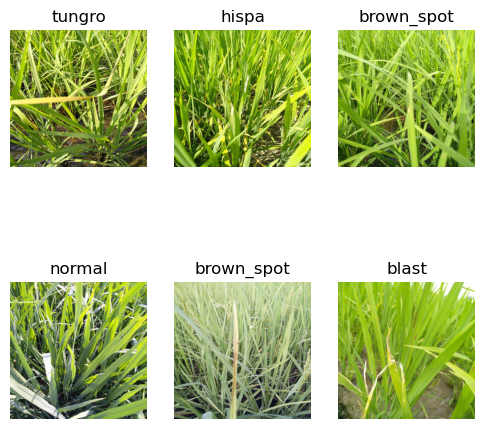

In [10]:
dls.show_batch(max_n=6, figsize=(6, 6))

## Model 1 -  resnet18

In [58]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(valley=0.001737800776027143, steep=0.001737800776027143)

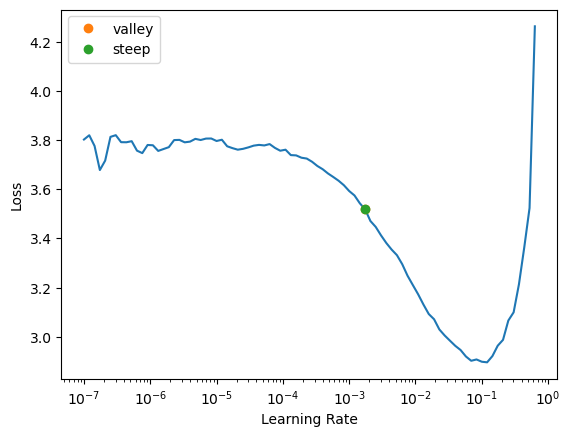

In [59]:
learn.lr_find(suggest_funcs=(valley, steep))

In [60]:
learn.fit_one_cycle(5, 0.001)

epoch,train_loss,valid_loss,error_rate,time
0,2.063485,0.966618,0.313311,01:39
1,1.095845,0.628036,0.191735,01:39
2,0.708963,0.511445,0.153292,01:50
3,0.512897,0.439629,0.130226,02:04
4,0.452930,0.429425,0.128784,01:47


In [61]:
learn.fine_tune(3, 0.001)

epoch,train_loss,valid_loss,error_rate,time
0,0.457097,0.423972,0.128784,01:39


epoch,train_loss,valid_loss,error_rate,time
0,0.330180,0.314772,0.089380,02:13
1,0.197259,0.266334,0.078328,02:46
2,0.086347,0.254885,0.071600,02:48


In [79]:
valid = learn.dls.valid
p, t = learn.get_preds(dl=valid)
error_rate(p, t)

TensorBase(0.0716)

In [82]:
p_tta, _ = learn.tta(dl=valid)
error_rate(p_tta, t)

TensorBase(0.0716)

In [18]:
def get_valid_err(model):
    valid_dls = model.dls.valid
    preds, targs = model.get_preds(dl=valid_dls)
    return error_rate(preds, targs)

In [19]:
def get_valid_tta_err(model, tta=True):
    valid_dls = model.dls.valid
    preds, targs = model.get_preds(dl=valid_dls)
    p_tta, _ = model.tta(dl=valid_dls)
    return error_rate(p_tta, targs)

## Model 2 - resnet50 with pretrained weights
- from torchvision (PyTorch official)

In [90]:
from torchvision.models import ResNet50_Weights
dls2 = ImageDataLoaders.from_folder(train_path, 
                                   seed=44, 
                                   valid_pct=0.2, 
                                   item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                                    batch_tfms= custom_transforms)

learn2 = vision_learner(dls2, arch=models.resnet50, 
                        pretrained=True, 
                        weights=ResNet50_Weights.IMAGENET1K_V2,
                        metrics=error_rate)

In [91]:
learn2.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.688171,1.238417,0.410860,01:30


epoch,train_loss,valid_loss,error_rate,time
0,0.666437,0.552147,0.163383,01:27
1,0.300395,0.224930,0.061989,01:25
2,0.101188,0.169821,0.047573,01:27


In [96]:
get_valid_err(learn2)

TensorBase(0.0476)

Kaggle Score: 0.96078

In [103]:
get_valid_tta_err(learn2)

TensorBase(0.0399)

### tta (test time augmentation)

In [106]:
p,_ = learn2.tta(dl=learn2.dls.valid, use_max=True)
p

tensor([[4.5763e-04, 4.5095e-04, 1.5631e-06,  ..., 3.9096e-05, 1.5581e-06,
         2.8004e-03],
        [1.0287e-10, 4.1557e-09, 1.2893e-05,  ..., 2.8543e-08, 1.0646e-05,
         3.8173e-10],
        [1.2561e-06, 7.2941e-06, 1.7294e-07,  ..., 5.3615e-06, 2.7482e-07,
         8.3145e-06],
        ...,
        [8.2348e-05, 1.3271e-06, 7.9483e-06,  ..., 9.9965e-01, 4.1221e-05,
         2.7738e-05],
        [3.9878e-06, 1.3005e-05, 1.0848e-03,  ..., 1.1641e-03, 9.9678e-01,
         1.3953e-04],
        [1.6809e-03, 1.9581e-03, 3.0411e-04,  ..., 9.9610e-01, 1.3485e-02,
         1.6870e-03]])

In [112]:
p.argmax(dim=1)

torch.Size([2081])

using tta - Kaggle Score: 0.96578

## Define a training function for automation

quick train with fine-tune:

In [11]:
def train_simple(arch, item, batch, epochs=3):
    dls = ImageDataLoaders.from_folder(train_path, seed=44, valid_pct=0.2,item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls, arch, metrics=error_rate)
    learn.fine_tune(epochs, 0.01)
    return learn

Add 'gradient accumulation' `accum=1` and 'fine-tune' option:

In [12]:
def train_accum(arch, item, batch, epochs=3, accum=1, finetune=True):
    dls = ImageDataLoaders.from_folder(train_path, seed=44, valid_pct=0.2, item_tfms=item, batch_tfms=batch, bs = 64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, cbs=cbs, metrics=error_rate)
    if finetune:
        learn.fine_tune(epochs, 0.01)
        #learn.tta(dl = dls.test_dl(test_file))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)
    return learn

In [16]:
def train_pytorch(arch, item, batch, epochs=3):
    dls = ImageDataLoaders.from_folder(train_path, seed=44, valid_pct=0.2,
                                       item_tfms=item, batch_tfms=custom_transforms)
    learn = vision_learner(dls, 
                           arch=models.resnet50, 
                           pretrained=True, 
                           weights=ResNet50_Weights.IMAGENET1K_V2, 
                           metrics=error_rate)
    learn.fine_tune(epochs, 0.01)
    return learn

## Testset submit function for automation

In [23]:
test_file = get_image_files(path/'test_images').sorted()
test_dls = dls.test_dl(test_file)
classes = dict(enumerate(dls.vocab))

In [71]:
preds,_,idxs = learn.get_preds(dl=test_dls, with_decoded=True)

In [74]:
classes = dict(enumerate(dls.vocab))
results = pd.Series(to_np(idxs)).map(classes)

In [83]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['label'] = results
submit.to_csv(path/'submission.csv', index=False)
!head submission.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


1st Kaggle Score: 0.94930

In [21]:
def get_submission(model, dls, file_name, tta=False):
    test_dls = dls.test_dl(test_file)
    if tta:
        p,_ = model.tta(dl=test_dls, use_max=True)
        idxs = p.argmax(dim=1)
    else:
        p,_,idxs = model.get_preds(dl=test_dls, with_decoded=True)
    results = pd.Series(to_np(idxs)).map(classes)
    submit = pd.read_csv(path/'sample_submission.csv')
    submit['label'] = results
    return submit.to_csv(path/file_name, index=False)

In [115]:
get_submission(learn2, dls2, 'submission_2.csv', tta=True)

## Model 3 - timm models
- With limited computation resource, I compared the models from this link and choose `convnext_tiny` model.
    - https://huggingface.co/timm/convnext_small.fb_in22k

gc 是 Python 的垃圾回收模块，用于手动清理无用对象，释放内存。

In [131]:
import gc
def clear_mps():
    gc.collect()
    torch.mps.empty_cache()

In [132]:
clear_mps()

In [135]:
learn3 = train_accum('convnext_tiny.in12k_ft_in1k', 
               item=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), 
               batch=custom_transforms,
              accum=1,
              finetune=True)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.269661,0.873942,0.283518,02:06


epoch,train_loss,valid_loss,error_rate,time
0,1.240456,2.869094,0.614128,15:12
1,1.103225,3.415100,0.665545,15:45
2,0.720894,0.531408,0.162902,15:20


In [136]:
get_valid_tta_err(learn3)

TensorBase(0.1543)

In [ ]:
learn3_1 = train('convnext_tiny.in12k_ft_in1k', 
               item=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), 
               batch=custom_transforms,
              accum=1,
              finetune=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.296115,0.966157,0.313791,01:42


epoch,train_loss,valid_loss,error_rate,time
0,1.218837,1.614616,0.470447,11:26


It takes >15mins per epoch in training. It is not good.

## Model 4 - EfficientNet

In [17]:
from torchvision.models import EfficientNet_V2_S_Weights
arch = models.EfficientNet
item = Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1

learn4 = train_pytorch(arch, item, custom_transforms, epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.720265,1.202415,0.394522,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.667309,0.469889,0.135031,01:18
1,0.327703,0.215920,0.066314,01:18
2,0.107009,0.166177,0.046132,01:21


In [20]:
get_valid_tta_err(learn4)

TensorBase(0.0380)

In [24]:
get_submission(learn4, learn4.dls, 'sub.csv', tta=True)

## Model 5 - Swin Transformers V2
### swin_v2_t (swin v2 tiny version)

In [26]:
from torchvision.models import Swin_V2_T_Weights
arch = models.swin_v2_t
item = Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
weights = Swin_V2_T_Weights.IMAGENET1K_V1

learn5 = train_pytorch(arch, item, custom_transforms, epochs=5)

epoch,train_loss,valid_loss,error_rate,time
0,1.710676,1.221366,0.393080,01:04


epoch,train_loss,valid_loss,error_rate,time
0,0.666583,0.424236,0.129265,01:19
1,0.415926,0.366254,0.105238,01:18
2,0.207107,0.291040,0.075925,01:19
3,0.089601,0.158180,0.037963,01:25
4,0.035546,0.160107,0.041326,01:19


In [27]:
get_valid_tta_err(learn5)

TensorBase(0.0380)

In [28]:
get_submission(learn5, learn5.dls, 'sub5.csv', tta=True)

Score: 0.97577

### swin_v2_s (small version)

In [32]:
from torchvision.models import Swin_V2_S_Weights
arch = models.swin_v2_s
item = Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
weights = Swin_V2_S_Weights.IMAGENET1K_V1

learn5_1 = train_pytorch(arch, item, custom_transforms, epochs=5)
get_valid_tta_err(learn5_1)

epoch,train_loss,valid_loss,error_rate,time
0,1.753597,1.263385,0.410380,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.668285,0.456556,0.136473,01:22
1,0.422422,0.345775,0.098991,01:23
2,0.243043,0.240209,0.067275,01:24
3,0.088611,0.185931,0.044690,01:23
4,0.033011,0.169605,0.040846,01:22


TensorBase(0.0375)

In [35]:
get_submission(learn5_1, learn5_1.dls, 'sub_swin.csv', tta=True)

Score: 0.97347

## Model 6 - Vision Transformer

In [36]:
from torchvision.models import ViT_B_16_Weights
arch = models.vit_b_16
item = Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

learn6 = train_pytorch(arch, item, custom_transforms, epochs=5)
get_valid_tta_err(learn6)

epoch,train_loss,valid_loss,error_rate,time
0,1.768015,1.201813,0.390678,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.680995,0.442358,0.132148,01:21
1,0.421029,0.508654,0.127823,01:23
2,0.242042,0.230591,0.062951,01:22
3,0.096010,0.182598,0.044690,01:30
4,0.034476,0.162900,0.040365,01:24


TensorBase(0.0375)

In [37]:
get_submission(learn6, learn6.dls, 'sub6.csv', tta=True)

Score: 0.97616 ⭐️so far the best

## Model 7 - RegNet
RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1 
- Acc@5: 98.054 Params: 83.6M

In [38]:
from torchvision.models import RegNet_Y_16GF_Weights
arch = models.regnet_y_16gf
item = Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
weights = RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1

learn7 = train_pytorch(arch, item, custom_transforms, epochs=5)
get_valid_tta_err(learn7)

epoch,train_loss,valid_loss,error_rate,time
0,1.712803,1.188449,0.371456,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.661713,0.491100,0.150889,01:22
1,0.429945,0.302662,0.098991,01:22
2,0.230008,0.228244,0.062951,01:22
3,0.088133,0.159666,0.044210,01:23
4,0.036307,0.146524,0.041326,01:26


TensorBase(0.0384)

Score: 0.97001

In [39]:
get_submission(learn7, learn7.dls, 'sub_regnet.csv', tta=True)

## Comparison performance & Interpretation

| Model.weights                                | Learner| Acc@5 IMAGENET1K | Params | Valid-tta-Error | Paddy - Public Score |
|----------------------------------------------|----------|----------|--------|-----------------|----------------------|
| ResNet18_Weights.IMAGENET1K_V1               | learn  |89.078    | 11.7M  | 0.0716          | 0.96078              |
| ResNet50_Weights.IMAGENET1K_V2               | learn2  |95.434    | 25.6M  | 0.0399          | 0.96578              |
| EfficientNet_V2_S_Weights.IMAGENET1K_V1      | learn4  |96.878    | 21.5M  | 0.0380          | 0.96424              |
| Swin_V2_T_Weights.IMAGENET1K_V1              | learn5  |96.132    | 28.4M  | 0.0380          | 0.97577 ⭐️           |
| Swin_V2_S_Weights.IMAGENET1K_V1              | learn5_1  |96.816    | 49.7M  | 0.0375          | 0.97347              |
| ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1      | learn6  |97.65     | 86.9M  | 0.0375          | 0.97616 ⭐️           |
| RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1 | learn7  |98.054✅  | 83.6M  | 0.0384          | 0.97001              |
| Ensemble of Swin, ViT (Best score) | learn5+learn7|--|--|--|0.97923 👍|

Possible reasons of 'the differ': RegNet has highest accuracy, but ViT, Swin are performing better in Paddy dataset.
- **Domain gap**
    - All weights pretrained are from IMAGENET1K dataset, the 1,000 categories (cat, dog, people) are quite different the Paddy dataset, which images are needed to focus on color, texture or spots...
- **Different sensitivities of architectures to image details**
    - ViT and Swin have potential advantages in leaf disease recognition, even though their accuracy on ImageNet is slightly lower.
    - Swin Transformer / ViT: Equipped with spatial attention mechanism, it can pay more attention to the detailed features in the image, especially suitable for tasks like "local changes are obvious" such as leaf lesions.
    - RegNet: Mainly based on convolution, although it has SE modules, the receptive field of convolutional layers remains fixed, and it may not be as sensitive to "fine spots" as attention is. 

## Ensemble of Swin, ViT

In [49]:
res_ens = []
#swin results
res_swin= learn5.tta(dl=learn5.dls.test_dl(test_file), use_max=True) 
#res_swin = (pred1, targ1),(pred2, targ2),...
res_ens.append(res_swin)

#vit results
res_vit = learn6.tta(dl=learn6.dls.test_dl(test_file),use_max=True)
res_ens.append(res_vit)

#select the preds only
tta_preds=first(zip(*res_ens)) # tta_pred= (swin-pred1, swin-pred2...),(vit-pred1,vit-pred2...)

#average swin-preds & vit_preds
avg_pr = torch.stack(tta_preds).mean(0)
avg_pr.shape

torch.Size([3469, 10])

In [51]:
idxs = avg_pr.argmax(dim=1)
results = pd.Series(to_np(idxs)).map(classes)
submit=pd.read_csv(path/'sample_submission.csv')
submit['label'] = results
submit.to_csv(path/'sub_env.csv', index=False)

Score: 0.97923 👍⭐️